In [10]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
import statsmodels.api as sm


In [17]:
path = "/Users/sami/Desktop/data.csv"
data = pd.read_csv(path,sep=',')
data.shape

(451113, 4)

In [7]:
data.head()

,ticker,date,last,volume
0,1332 JT,2013-01-04,169.0987,1464100
1,1332 JT,2013-01-07,166.3266,1783500
2,1332 JT,2013-01-08,166.3266,1759800
3,1332 JT,2013-01-09,165.4026,767800
4,1332 JT,2013-01-10,167.2507,1503100


I define the net return of a stock as : $$(p_{t+1}-p_{t})/p_{t}$$

My strategy consists of prediciting the return for each stock using the following method : I do the regression of the current return $r_t$ on the previous return $r_{t-1}$ and the log of the volume. So we have the following regression :
$$ r_t = \alpha*r_{t-1} + \beta*log(volume) + \epsilon$$.

Being at a time step $t$, I use all the date previous to the instant $t$ to compute the regression. This allows me to predict the return at the next time step $\hat{r}_{t+1}$ and this is my signal $s_{t}$ (indexed by $t$ insted of $t+1$ because it is available at time $t$). And I simply decide to take the following position on the stock of interest : $\hat{r}_{t+1}/\sigma_t$.   $\sigma_t$ being the standard deviation of the return on a rolling window of 50 past days : the higher the volatility of a stock, the less I want to take big positions on it. 

In [4]:
#this function takes the raw data as an input and returns a dictionnary contaning the dataframe of each stock. 
def prepare_data(data):
    a =data['ticker'].value_counts().to_frame()
    tickers = a.loc[a['ticker']==2005].index
    data_tickers = dict()
    for tick in tickers :
        df = data[data['ticker']==tick]
        df['return'] = (df['last']-df['last'].shift(1))/df['last'].shift(1)
        data_tickers[tick] = df
    return data_tickers
        

In [38]:
#this function returns the signal (wichh is the estimated future return) given all the previous returns and volumes  

def get_signal(date,ticker,data_dict,volume):
    df = data_dict[data_dict['date'] <= date]
    n = len(df['return'])
    df['log_volume'] = np.log(df['volume'])
    df['return_shifted'] = df['return'].shift(1)
    
    y = df['return'][2:n]
    std = df['return'].std()
    if volume == True :
        X = df[['return_shifted','volume']][2:n]
        model = sm.OLS(y,X).fit()
        return model.predict(df[['return','log_volume']].loc[df['date']==date]).values[0]/std
    
    else : 
        x = df['return'].shift(1)[2:n]
        model = sm.OLS(y, x).fit()
        return model.predict(df['return'].loc[df['return']==date])/std
    
    
    

    

In [33]:
def get_return(date,ticker,dict_data):
    df = dict_data[ticker]
    return df.loc[df['date']==date]['return'].unique()[0]
    

For the backtest, I proceeded as follows. I firstly define the following quantities : $portfolio_{t}$ wich is the amount of dollar invested in the stock at time t, $PnL_{t}$ wich is the gain between day $t$ and day $t+1$, an initial amount of cash $cash_0$(hereafter I set it to 10), and $cash_t$ the amount of cash at time $t$, $action_{t}$ wich is the amount of dollar of sotck to buy or sell at time $t+1$. The evolution of these quantities is determined by these equations : 
$$PnL_{t+1} = s_t*r_{t+1} = \hat{r}_{t+1}*r_{t+1}$$
$$action_{t+1} = s_{t+1} - Portofolio_{t}*(1+r_{t+1})$$
$$cash_{t+1} = cash_{t} - action_{t+1}$$
At the end of the day $t+1$, the amount of dollar invested in the stock is by construction $portoflio_{t+1}=s_{t+1}$.

The variable 'begin_test' is the day at wich I start testing my strategy, beacuse in order to estimate my signal I need some previous data. (so I can't start testing at the first day).

Just below is printed the signal, the daily PnL and the (cash+money in stock) curve of one stock. In order to evaluate my strategy I use the sharpe ratio which is equal to (or we can use also the total money I think): $$E[PnL]/\sqrt{Var[PnL]}$$ 

In [48]:
from statistics import mean


def backtest2(data,ticker,begin_test):
    
    dict_data = prepare_data(data)
    data_ticker = dict_data[ticker]
    

    Dates = dict_data[ticker]['date'].tolist()
    
    initial_date =  Dates[begin_test]
    Portfolio = get_signal(initial_date,ticker,data_ticker,True)
    Cash = 10
    
    PnL = []
    Signal= []
    Cash_serie = []

    for t in range(begin_test,len(Dates)-1):
        date = Dates[t+1]
        Return = get_return(date,ticker,dict_data)
        #print(Return,Portfolio)
        pnl = Return*Portfolio
        #print(pnl)
        PnL.append(pnl)
        #print(date,ticker)
        Portoflio = Portfolio*(1+Return)
        
        next_signal = get_signal(date,ticker,data_ticker,True)
        Signal.append(next_signal)
        
        action = next_signal - Portfolio
        
        Cash = Cash - action
        Cash_serie.append(Cash)
        
        Portfolio = 10*next_signal #here I only mutliply the signal by 10 to have more visible graphs (doesn't change the performance)
        
    return (Signal,PnL,Cash_serie)
    
    
    
    

/Users/sami/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/Users/sami/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


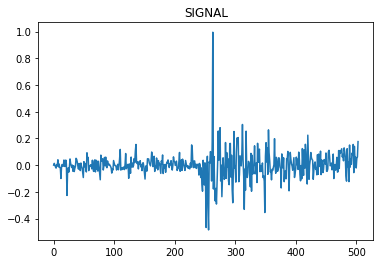

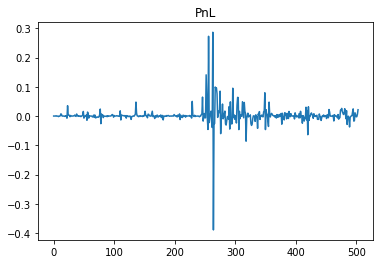

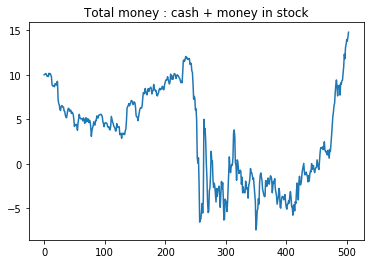

The sharpe ratio of this strategy on a single stock is 0.06886663589429445


In [50]:
Signal,PnL,Cash_serie = backtest2(data,'8304 JT',1500)

plt.plot(Signal)
plt.title('SIGNAL')
plt.show()
plt.plot(PnL)
plt.title('PnL')
plt.show()
plt.plot(np.array(Cash_serie)+np.array(Signal))
plt.title('Total money : cash + money in stock')
plt.show()

ratiosharpe = mean(PnL)/np.std(PnL)
print('The sharpe ratio of this strategy on a single stock is ' + str(ratiosharpe))

# Multi-stock

In order to build a strategy with different stocks, we only apply the previous method to each one and sum the quantities. It is implemented below. I only take here 50 stocks so I doesn't take too much time calculation. If I were to improve this strategy, I would look for low correlated stocks to reduce the risk. 

In [77]:
def backtest_multi(data,begin_test):
    
    
    dict_data = prepare_data(data)
    
    PNLs=[]
    ACTIONS=[]
    
    for ticker in list(dict_data.keys())[0:50] : 
        data_ticker = dict_data[ticker]


        Dates = dict_data[ticker]['date'].tolist()

        initial_date =  Dates[begin_test]
        Portfolio = get_signal(initial_date,ticker,data_ticker,True)
        Cash = 10

        PnL = []
        Signal= []
        Cash_serie = []
        actions=[]

        for t in range(begin_test,len(Dates)-1):
            date = Dates[t+1]
            Return = get_return(date,ticker,dict_data)
            #print(Return,Portfolio)
            pnl = Return*Portfolio
            #print(pnl)
            PnL.append(pnl)
            #print(date,ticker)
            Portoflio = Portfolio*(1+Return)

            next_signal = get_signal(date,ticker,data_ticker,True)
            Signal.append(next_signal)

            action = next_signal - Portfolio
            actions.append(action)

            Cash = Cash - action
            Cash_serie.append(Cash)

            Portfolio = 10*next_signal 
            #here I only mutliply the signal by 10 to have more visible graphs (doesn't change the performance)
            
        PNLs.append(PnL)
        ACTIONS.append(actions)

    return(PNLs,ACTIONS)


/Users/sami/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/Users/sami/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/sami/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


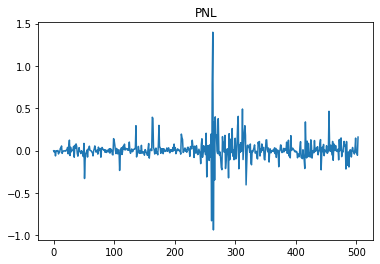

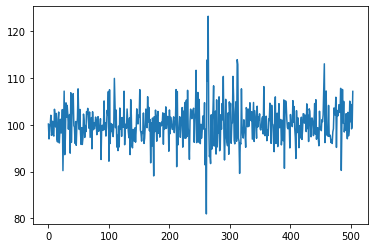

Sharpe ratio : 0.0707115176797193


In [78]:
PNLs,ACTIONS = backtest_multi(data,1500)

PNL = []
CASH=[]
cash_0 =100
for i in range(len(PNLs[0])):
    #print(i)
    PNL.append(sum(np.array(PNLs)[:,i]))
    CASH.append(cash_0-sum(np.array(ACTIONS)[:,i]))
    
plt.plot(PNL)
plt.title('PNL')
plt.show()

plt.plot(CASH)
plt.show()

print('Sharpe ratio : '+str(mean(PNL)/np.std(PNL)))